In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


In [2]:
ratings = pd.read_csv(r"C:\Users\akaha\Downloads\ratings.csv")
movies = pd.read_csv(r"C:\Users\akaha\Downloads\movies.csv")

print("Ratings shape:", ratings.shape)
print("Movies shape:", movies.shape)


Ratings shape: (20000263, 4)
Movies shape: (27278, 3)


In [3]:
ratings.head()


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [4]:
movies.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings["timestamp"] = pd.to_datetime(
    ratings["timestamp"], unit="s"
)

ratings.dtypes


userId                int64
movieId               int64
rating              float64
timestamp    datetime64[ns]
dtype: object

In [6]:
ratings.isnull().sum()


userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [7]:
ratings["rating"].describe()


count    2.000026e+07
mean     3.525529e+00
std      1.051989e+00
min      5.000000e-01
25%      3.000000e+00
50%      3.500000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

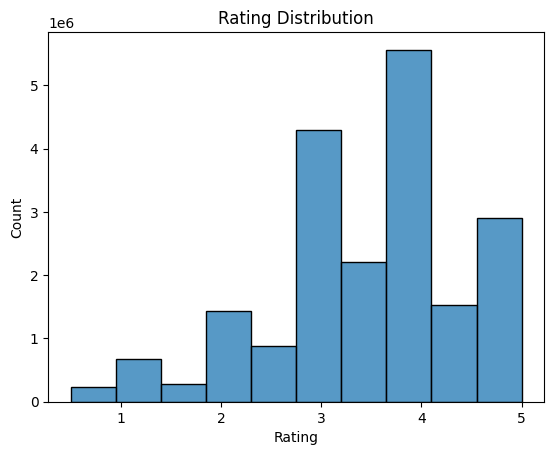

In [8]:
sns.histplot(ratings["rating"], bins=10)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.show()


In [9]:
user_activity = ratings.groupby("userId").size()
user_activity.describe()

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
dtype: float64

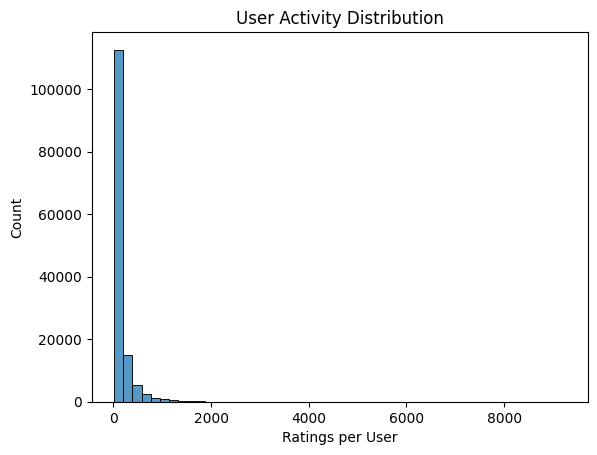

In [10]:
sns.histplot(user_activity, bins=50)
plt.xlabel("Ratings per User")
plt.title("User Activity Distribution")
plt.show()


In [11]:
ratings["timestamp"].min(), ratings["timestamp"].max()


(Timestamp('1995-01-09 11:46:44'), Timestamp('2015-03-31 06:40:02'))

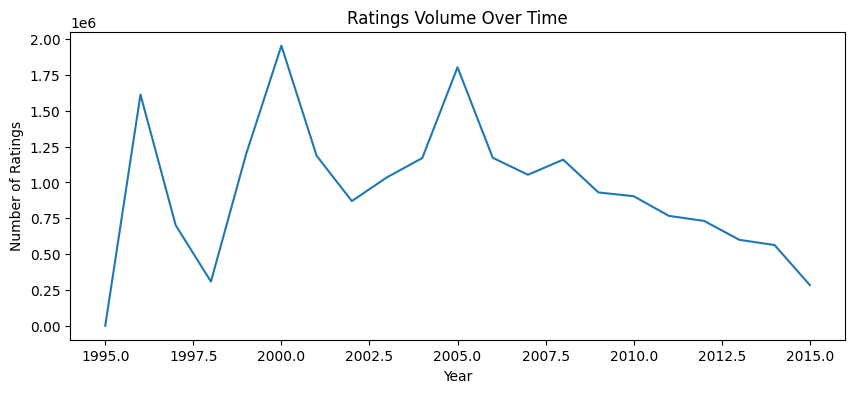

In [12]:
ratings.groupby(
    ratings["timestamp"].dt.year
).size().plot(figsize=(10,4))

plt.title("Ratings Volume Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Ratings")
plt.show()


In [13]:
user_lifespan = ratings.groupby("userId")["timestamp"].agg(["min", "max"])
user_lifespan["lifespan_days"] = (
    user_lifespan["max"] - user_lifespan["min"]
).dt.days

user_lifespan["lifespan_days"].describe()


count    138493.000000
mean        196.378958
std         627.607307
min           0.000000
25%           0.000000
50%           0.000000
75%          30.000000
max        6405.000000
Name: lifespan_days, dtype: float64

In [14]:
user_interaction_counts = ratings.groupby("userId").size().reset_index(name="num_interactions")

user_interaction_counts.head()


,userId,num_interactions
0,1,175
1,2,61
2,3,187
3,4,28
4,5,66


In [15]:
user_interaction_counts["num_interactions"].describe()


count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: num_interactions, dtype: float64

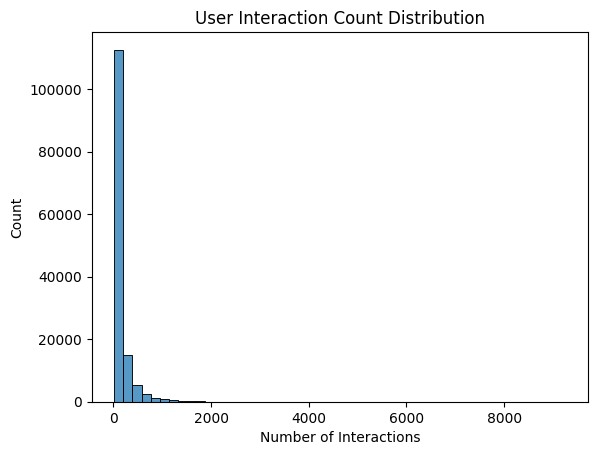

In [16]:
sns.histplot(user_interaction_counts["num_interactions"], bins=50)
plt.xlabel("Number of Interactions")
plt.title("User Interaction Count Distribution")
plt.show()


In [17]:
ratings_sorted = ratings.sort_values("timestamp").reset_index(drop=True)


In [18]:
ratings_sorted["interaction_number"] = (
    ratings_sorted
    .groupby("userId")
    .cumcount() + 1
)


In [19]:
COLD_START_THRESHOLD = 20
MATURE_THRESHOLD = 50


def assign_user_lifecycle_timeaware(n):
    if n < COLD_START_THRESHOLD:
        return "cold_start"
    elif n < MATURE_THRESHOLD:
        return "sparse"
    else:
        return "mature"

ratings_sorted["lifecycle_stage"] = (
    ratings_sorted["interaction_number"]
    .apply(assign_user_lifecycle_timeaware)
)

In [20]:
ratings_sorted["lifecycle_stage"].value_counts()


lifecycle_stage
mature        14155715
sparse         3213181
cold_start     2631367
Name: count, dtype: int64

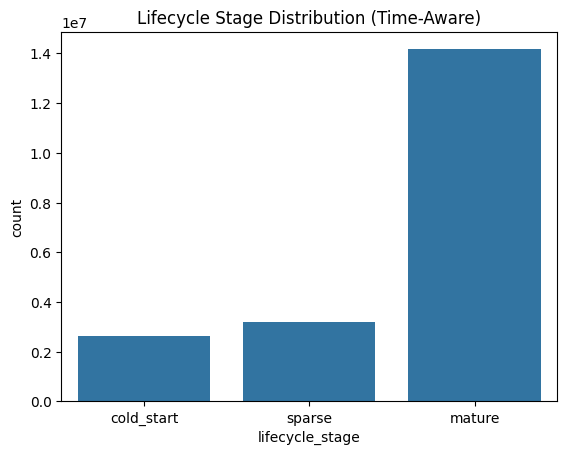

In [21]:
sns.countplot(
    data=ratings_sorted,
    x="lifecycle_stage",
    order=["cold_start", "sparse", "mature"]
)
plt.title("Lifecycle Stage Distribution (Time-Aware)")
plt.show()


In [22]:
ratings_sorted.head()


,userId,movieId,rating,timestamp,interaction_number,lifecycle_stage
0,28507,1176,4.0,1995-01-09 11:46:44,1,cold_start
1,131160,1079,3.0,1995-01-09 11:46:49,1,cold_start
2,131160,47,5.0,1995-01-09 11:46:49,2,cold_start
3,131160,21,3.0,1995-01-09 11:46:49,3,cold_start
4,85252,45,3.0,1996-01-29 00:00:00,1,cold_start


In [23]:
ratings_sorted.groupby("lifecycle_stage")["rating"].agg(["count", "mean"])


,count,mean
lifecycle_stage,,
cold_start,2631367,3.560618
mature,14155715,3.468122
sparse,3213181,3.749700


In [24]:
movies_cb = movies.copy()

movies_cb["genres"] = movies_cb["genres"].str.replace("|", " ", regex=False)
movies_cb.head()


,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance
3,4,Waiting to Exhale (1995),Comedy Drama Romance
4,5,Father of the Bride Part II (1995),Comedy


In [25]:
# Ensure datetime
ratings_sorted["timestamp"] = pd.to_datetime(ratings_sorted["timestamp"])

T_now = ratings_sorted["timestamp"].max()

# Recency in days
recency_days = (
    (T_now - ratings_sorted["timestamp"])
    .dt.total_seconds() / (60 * 60 * 24)
)

# Exponential decay
LAMBDA = 0.05
ratings_sorted["recency_weight"] = np.exp(-LAMBDA * recency_days)


In [26]:
movie_popularity = (
    ratings_sorted
    .groupby("movieId")["recency_weight"]
    .sum()
    .reset_index()
    .rename(columns={"recency_weight": "popularity_score"})
)

movie_popularity = movie_popularity.merge(movies, on="movieId")

movie_popularity.sort_values("popularity_score", ascending=False).head(10)


,movieId,popularity_score,title,genres
22801,109487,283.047307,Interstellar (2014),Sci-Fi|IMAX
2486,2571,275.461955,"Matrix, The (1999)",Action|Sci-Fi|Thriller
15513,79132,260.015792,Inception (2010),Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
315,318,234.551466,"Shawshank Redemption, The (1994)",Crime|Drama
7041,7153,230.547697,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy
12515,58559,229.569602,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX
4897,4993,222.462238,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
23506,112556,205.787701,Gone Girl (2014),Drama|Thriller
23574,112852,203.545402,Guardians of the Galaxy (2014),Action|Adventure|Sci-Fi
24453,116797,203.033539,The Imitation Game (2014),Drama|Thriller


In [27]:
def recommend_cold_start(k=10):
    return movie_popularity.head(k)[["movieId", "title"]]


In [28]:
ratings_sorted["weighted_rating"] = (
    ratings_sorted["rating"] * ratings_sorted["recency_weight"]
)


In [29]:
from sklearn.preprocessing import LabelEncoder

user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

ratings_sorted["user_idx"] = user_encoder.fit_transform(ratings_sorted["userId"])
ratings_sorted["item_idx"] = item_encoder.fit_transform(ratings_sorted["movieId"])


In [30]:
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(
    (
        ratings_sorted["weighted_rating"],
        (ratings_sorted["user_idx"], ratings_sorted["item_idx"])
    )
)


In [31]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(sparse_matrix)
item_factors = svd.components_


In [32]:
split_time = ratings_sorted["timestamp"].quantile(0.8)

train = ratings_sorted[ratings_sorted["timestamp"] <= split_time].copy()
test  = ratings_sorted[ratings_sorted["timestamp"] > split_time].copy()


In [33]:
train_user_items = (
    train.groupby("userId")["movieId"]
    .apply(set)
    .to_dict()
)


In [34]:
# Build sparse matrix using TRAIN data only
train["user_idx"], user_index = pd.factorize(train["userId"])
train["item_idx"], item_index = pd.factorize(train["movieId"])

from scipy.sparse import csr_matrix

train_sparse = csr_matrix(
    (
        train["weighted_rating"],
        (train["user_idx"], train["item_idx"])
    )
)

from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(train_sparse)
item_factors = svd.components_


In [35]:
def recommend_temporal_cf(user_id, k=10):
    if user_id not in user_index:
        return recommend_cold_start(k)

    user_idx = np.where(user_index == user_id)[0][0]
    scores = user_factors[user_idx] @ item_factors

    movie_scores = pd.Series(scores, index=item_index)

    watched = train_user_items.get(user_id, set())
    movie_scores = movie_scores.drop(watched, errors="ignore")

    top_movies = movie_scores.sort_values(ascending=False).head(k).index
    return movies[movies["movieId"].isin(top_movies)][["movieId", "title"]]


In [36]:
user_interaction_counts = train.groupby("userId").size()

def hybrid_recommend(user_id, k=10):
    n_interactions = user_interaction_counts.get(user_id, 0)
    stage = assign_user_lifecycle_timeaware(n_interactions)

    if stage == "cold_start":
        return recommend_cold_start(k)
    else:
        return recommend_temporal_cf(user_id, k)


In [37]:
# Cold-start user
hybrid_recommend(user_id=999999, k=5)

# Existing user
hybrid_recommend(user_id=1, k=5)


,movieId,title
843,858,"Godfather, The (1972)"
1172,1197,"Princess Bride, The (1987)"
1184,1210,Star Wars: Episode VI - Return of the Jedi (1983)
1480,1527,"Fifth Element, The (1997)"
2486,2571,"Matrix, The (1999)"


In [38]:
ratings_sorted = ratings_sorted.sort_values("timestamp")

split_time = ratings_sorted["timestamp"].quantile(0.8)

train = ratings_sorted[ratings_sorted["timestamp"] <= split_time]
test  = ratings_sorted[ratings_sorted["timestamp"] > split_time]


In [39]:
def precision_at_k(model_func, test_df, k=10):
    precisions = []

    for user in test_df["userId"].unique():
        true_items = test_df[test_df["userId"] == user]["movieId"].values
        recs = model_func(user, k)

        if len(recs) == 0:
            continue

        rec_items = recs["movieId"].values
        precision = len(set(rec_items) & set(true_items)) / k
        precisions.append(precision)

    return np.mean(precisions)


In [40]:
# cold_only_precision = precision_at_k(
#     lambda u, k: recommend_cold_start(k),
#     test
# )

# hybrid_precision = precision_at_k(
#     hybrid_recommend,
#     test
# )

# print("Cold-start only Precision@K:", cold_only_precision)
# print("Hybrid Precision@K:", hybrid_precision)


In [41]:
# Very small sample
tiny_users = (
    test["userId"]
    .drop_duplicates()
    .sample(50, random_state=42)
)

def quick_precision(model_func, users, k=5):
    hits = 0
    total = 0

    for user in users:
        true_items = test[test["userId"] == user]["movieId"].values
        if len(true_items) == 0:
            continue

        recs = model_func(user, k)
        if recs is None or len(recs) == 0:
            continue

        hits += len(set(recs["movieId"]) & set(true_items))
        total += k

    return hits / total if total > 0 else 0


In [42]:
print("Cold-only:", quick_precision(lambda u, k: recommend_cold_start(k), tiny_users))
print("Hybrid:", quick_precision(hybrid_recommend, tiny_users))


Cold-only: 0.104
Hybrid: 0.152


In [43]:
user_interaction_counts = ratings_sorted.groupby("userId").size()

mature_users = user_interaction_counts[
    user_interaction_counts >= MATURE_THRESHOLD
].index

tiny_mature_users = np.random.choice(mature_users, size=50, replace=False)


In [44]:
print(
    "Cold-only:",
    quick_precision(lambda u, k: recommend_cold_start(k), tiny_mature_users)
)

print(
    "Hybrid:",
    quick_precision(hybrid_recommend, tiny_mature_users)
)


Cold-only: 0.13333333333333333
Hybrid: 0.16


In [ ]:
#content based filtering

In [45]:
from sklearn.feature_extraction.text import TfidfVectorizer

movies_cb = movies.copy()
movies_cb["genres"] = movies_cb["genres"].str.replace("|", " ", regex=False)

tfidf = TfidfVectorizer(stop_words="english")
genre_tfidf = tfidf.fit_transform(movies_cb["genres"])


In [46]:
import numpy as np

def recommend_content_cold_start(k=10):
    # take top popular movies
    top_popular = movie_popularity.head(100)["movieId"].values
    idxs = movies_cb[movies_cb["movieId"].isin(top_popular)].index

    # diversify using TF-IDF similarity
    centroid = genre_tfidf[idxs].mean(axis=0)
    scores = genre_tfidf @ centroid.T

    top_idxs = np.argsort(scores.A.ravel())[::-1][:k]
    return movies_cb.iloc[top_idxs][["movieId", "title"]]


In [47]:
def hybrid_recommend(user_id, k=10):
    n_interactions = user_interaction_counts.get(user_id, 0)
    stage = assign_user_lifecycle_timeaware(n_interactions)

    if stage == "cold_start":
        return recommend_content_cold_start(k)
    else:
        return recommend_temporal_cf(user_id, k)


In [48]:
def recall_at_k(model_func, test_df, users, k=10):
    recalls = []

    for user in users:
        true_items = set(test_df[test_df["userId"] == user]["movieId"])
        if len(true_items) == 0:
            continue

        recs = model_func(user, k)
        if recs is None or len(recs) == 0:
            continue

        rec_items = set(recs["movieId"])
        recalls.append(len(rec_items & true_items) / len(true_items))

    return np.mean(recalls)


In [49]:
import math

def ndcg_at_k(recommended, relevant, k):
    dcg = 0.0
    for i, item in enumerate(recommended[:k]):
        if item in relevant:
            dcg += 1 / math.log2(i + 2)

    idcg = sum(1 / math.log2(i + 2) for i in range(min(len(relevant), k)))
    return dcg / idcg if idcg > 0 else 0


In [50]:
def mean_ndcg_at_k(model_func, test_df, users, k=10):
    scores = []

    for user in users:
        relevant = set(test_df[test_df["userId"] == user]["movieId"])
        if len(relevant) == 0:
            continue

        recs = model_func(user, k)
        if recs is None or len(recs) == 0:
            continue

        recommended = recs["movieId"].tolist()
        scores.append(ndcg_at_k(recommended, relevant, k))

    return np.mean(scores)


In [51]:
EVAL_USERS = (
    test["userId"]
    .drop_duplicates()
    .sample(50, random_state=42)
)


In [52]:
print("Precision@5 Results")
print("-" * 30)

cold_p = quick_precision(
    lambda u, k: recommend_content_cold_start(k),
    EVAL_USERS,
    k=5
)

hybrid_p = quick_precision(
    hybrid_recommend,
    EVAL_USERS,
    k=5
)

print(f"Cold-start Precision@5 : {cold_p:.4f}")
print(f"Hybrid Precision@5     : {hybrid_p:.4f}")
print(f"Relative Improvement   : {(hybrid_p - cold_p) / cold_p * 100:.2f}%")


Precision@5 Results
------------------------------
Cold-start Precision@5 : 0.0040
Hybrid Precision@5     : 0.1520
Relative Improvement   : 3700.00%


In [53]:
print("\nRecall@5 Results")
print("-" * 30)

cold_r = recall_at_k(
    lambda u, k: recommend_content_cold_start(k),
    test,
    EVAL_USERS,
    k=5
)

hybrid_r = recall_at_k(
    hybrid_recommend,
    test,
    EVAL_USERS,
    k=5
)

print(f"Cold-start Recall@5 : {cold_r:.4f}")
print(f"Hybrid Recall@5     : {hybrid_r:.4f}")
print(f"Relative Improvement: {(hybrid_r - cold_r) / cold_r * 100:.2f}%")



Recall@5 Results
------------------------------
Cold-start Recall@5 : 0.0001
Hybrid Recall@5     : 0.0088
Relative Improvement: 10672.78%


In [54]:
print("\nNDCG@5 Results")
print("-" * 30)

cold_ndcg = mean_ndcg_at_k(
    lambda u, k: recommend_content_cold_start(k),
    test,
    EVAL_USERS,
    k=5
)

hybrid_ndcg = mean_ndcg_at_k(
    hybrid_recommend,
    test,
    EVAL_USERS,
    k=5
)

print(f"Cold-start NDCG@5 : {cold_ndcg:.4f}")
print(f"Hybrid NDCG@5     : {hybrid_ndcg:.4f}")
print(f"Relative Improvement: {(hybrid_ndcg - cold_ndcg) / cold_ndcg * 100:.2f}%")



NDCG@5 Results
------------------------------
Cold-start NDCG@5 : 0.0029
Hybrid NDCG@5     : 0.1946
Relative Improvement: 6562.21%
